In [33]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import matplotlib.pyplot as plt
print(tf.config.list_physical_devices('GPU'))

[]


In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
latent_dim = 3

inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Dropout(0.1)(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Dropout(0.1)(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
#encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
#encoder.summary()

In [4]:
#mean, var, z = encoder(inputs)
#latent_inputs = keras.Input(shape=(latent_dim,))
#z_inputs = layers.concatenate([z,latent_inputs],axis = 0,name="concatenated_layer")
x_1 = layers.Dense(7 * 7 * 64, activation="relu")(z)
x = layers.Reshape((7, 7, 64))(x_1)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
#decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
#decoder.summary()
vae_m = keras.Model(inputs,decoder_outputs,name="vae")
vae_m.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 7, 7, 64)             0         ['conv2d_1[0][0]']            
                                                                                                

In [5]:
layer_names = ['z_mean','z_log_var','sampling']
encoder_model = keras.Model(inputs=vae_m.input,
                                 outputs=[vae_m.get_layer(layer).output for layer in layer_names],name="encoder")
encoder_model.summary()
decoder_model = keras.Model(inputs=vae_m.get_layer(layer_names[2]).output,
                                 outputs=vae_m.output, name="decoder")
decoder_model.summary()
#intermediate_output = intermediate_layer_model.predict(data)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 7, 7, 64)             0         ['conv2d_1[0][0]']            
                                                                                            

In [6]:
#Added a classifier 
clf_latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling_clf')
clf_outputs = layers.Dense(10, activation='softmax', name='class_output')(clf_latent_inputs)
clf_supervised = keras.Model(clf_latent_inputs, clf_outputs, name='clf')
clf_supervised.summary()

Model: "clf"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling_clf (InputLayer  [(None, 3)]               0         
 )                                                               
                                                                 
 class_output (Dense)        (None, 10)                40        
                                                                 
Total params: 40 (160.00 Byte)
Trainable params: 40 (160.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder,classifier,y_train,batch_size, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier
        self.y_input = y_train
        self.batch_size = batch_size
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.class_loss_tracker = keras.metrics.Mean(name="class_loss")
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.class_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            
                
            z_mean, z_log_var, z = self.encoder(data)
            y_hat = self.classifier(z)
            
            y_train = np.random.choice(self.y_input,self.batch_size)
            reconstruction = self.decoder(z)

            #Image Reconstruction Loss
            reconstruction_loss = 0.05* tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            #Classifier Loss 
            class_loss = keras.losses.sparse_categorical_crossentropy(y_train,y_hat)

            #KL Divergence Loss

            kl_loss = -0.05 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + class_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.class_loss_tracker.update_state(class_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "class_loss": self.class_loss_tracker.result(),
        }

In [19]:
(x_train, l_train), (x_test, l_test) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255


mnist_labels = np.concatenate([l_train, l_test], axis=0)
#data = np.stack([mnist_digits,mnist_labels],axis=1)
batch = 100
vae = VAE(encoder_model, decoder_model, clf_supervised, mnist_labels,batch)
vae.compile(optimizer=keras.optimizers.Adam(0.0001))
vae.fit(mnist_digits, epochs=20, batch_size=batch)

Epoch 1/20
700/700 [==============================] - 7s 8ms/step - loss: 8.4331 - reconstruction_loss: 6.1036 - kl_loss: 1.2964 - class_loss: 2.3029
Epoch 2/20
700/700 [==============================] - 6s 8ms/step - loss: 8.3843 - reconstruction_loss: 6.0776 - kl_loss: 1.4991 - class_loss: 2.2865
Epoch 3/20
700/700 [==============================] - 6s 8ms/step - loss: 8.3492 - reconstruction_loss: 6.0655 - kl_loss: 1.5902 - class_loss: 2.2781
Epoch 4/20
700/700 [==============================] - 6s 8ms/step - loss: 8.3297 - reconstruction_loss: 6.0550 - kl_loss: 1.6516 - class_loss: 2.2734
Epoch 5/20
700/700 [==============================] - 6s 8ms/step - loss: 8.3123 - reconstruction_loss: 6.0471 - kl_loss: 1.7098 - class_loss: 2.2701
Epoch 6/20
700/700 [==============================] - 6s 8ms/step - loss: 8.3048 - reconstruction_loss: 6.0384 - kl_loss: 1.7451 - class_loss: 2.2683
Epoch 7/20
700/700 [==============================] - 6s 8ms/step - loss: 8.3069 - reconstruction_lo

In [15]:




def plot_latent_space(vae, n=30, figsize=15):
    # display an n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

ValueError: in user code:

    File "/home/aparame/.local/lib/python3.9/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/home/aparame/.local/lib/python3.9/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/aparame/.local/lib/python3.9/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/home/aparame/.local/lib/python3.9/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/home/aparame/.local/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/aparame/.local/lib/python3.9/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "decoder" is incompatible with the layer: expected shape=(None, 3), found shape=(None, 2)


In [20]:
from operator import itemgetter
from itertools import groupby

(x_train, y_train), (x_test,y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

_,_,z = encoder_model.predict(x_test)
l = zip(z,y_test)
sort_list = sorted(l,key = itemgetter(1))
#print(sort_list)
final_list = []
for i in range(9):
    sorted_list = [values for values,key in sort_list if key == i]

#[print(k,list(g)) for k,g in groupby(sort_list, lambda x: x[1])]  
#print(listed)

313/313 [==============================] - 0s 1ms/step


1875/1875 [==============================] - 2s 1ms/step


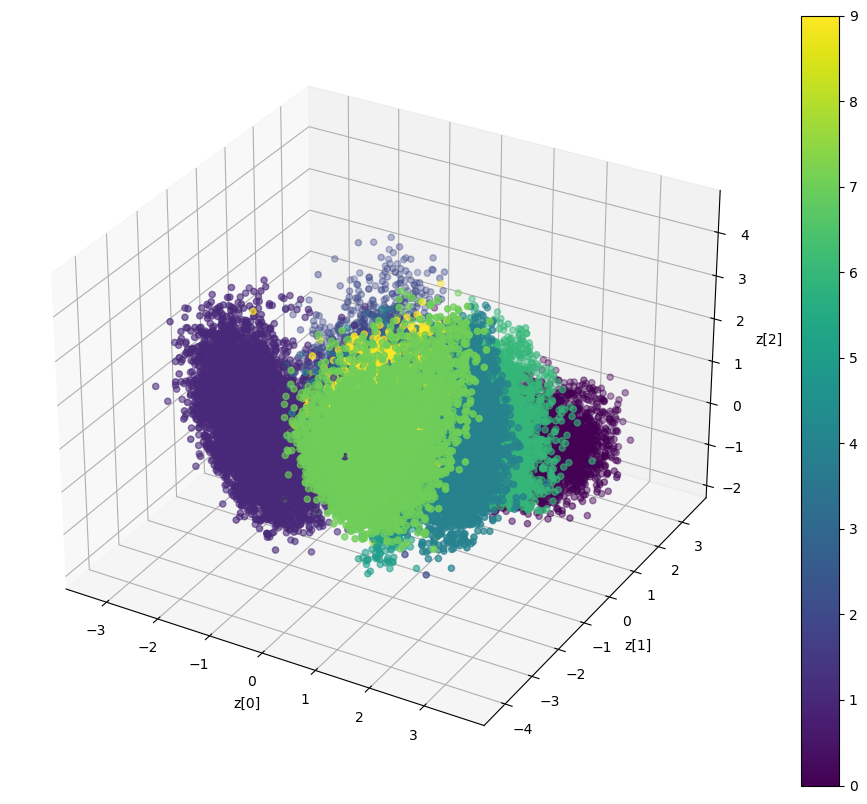

In [34]:

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(projection="3d")
    p = ax.scatter(z_mean[:, 0], z_mean[:, 1], z_mean[:,2], c=labels)
    fig.colorbar(p)
    ax.set_xlabel("z[0]")
    ax.set_ylabel("z[1]")
    ax.set_zlabel("z[2]")
    plt.show()


(x_train, y_train), (x_test,y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

1875/1875 [==============================] - 2s 1ms/step


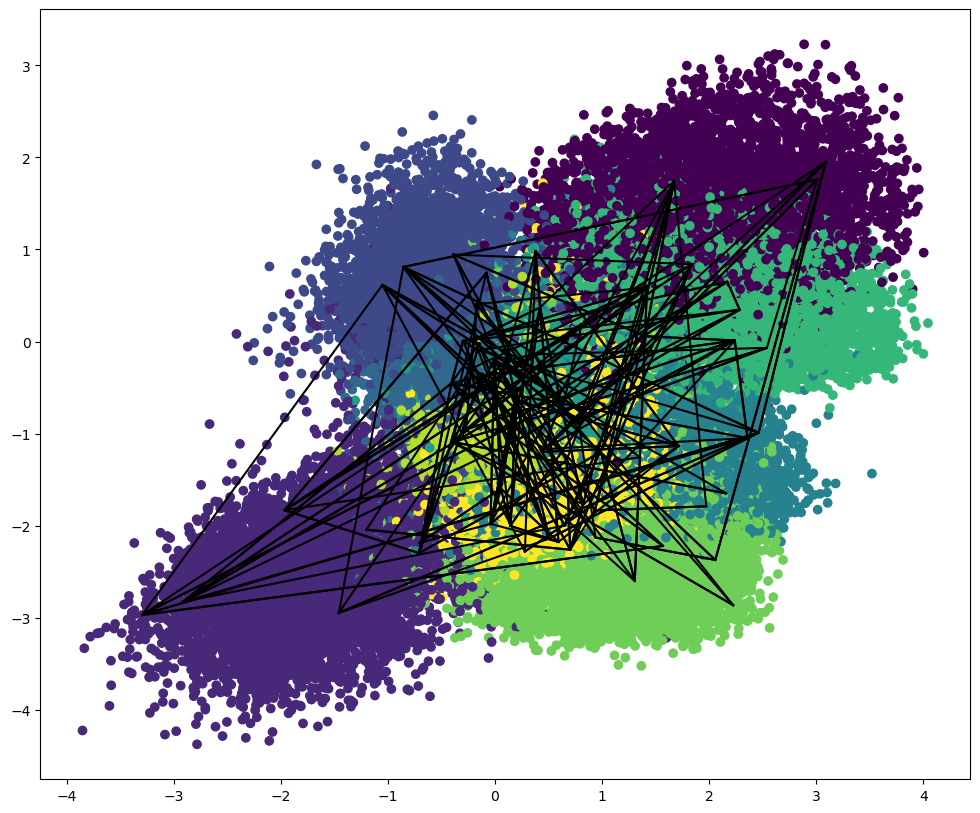

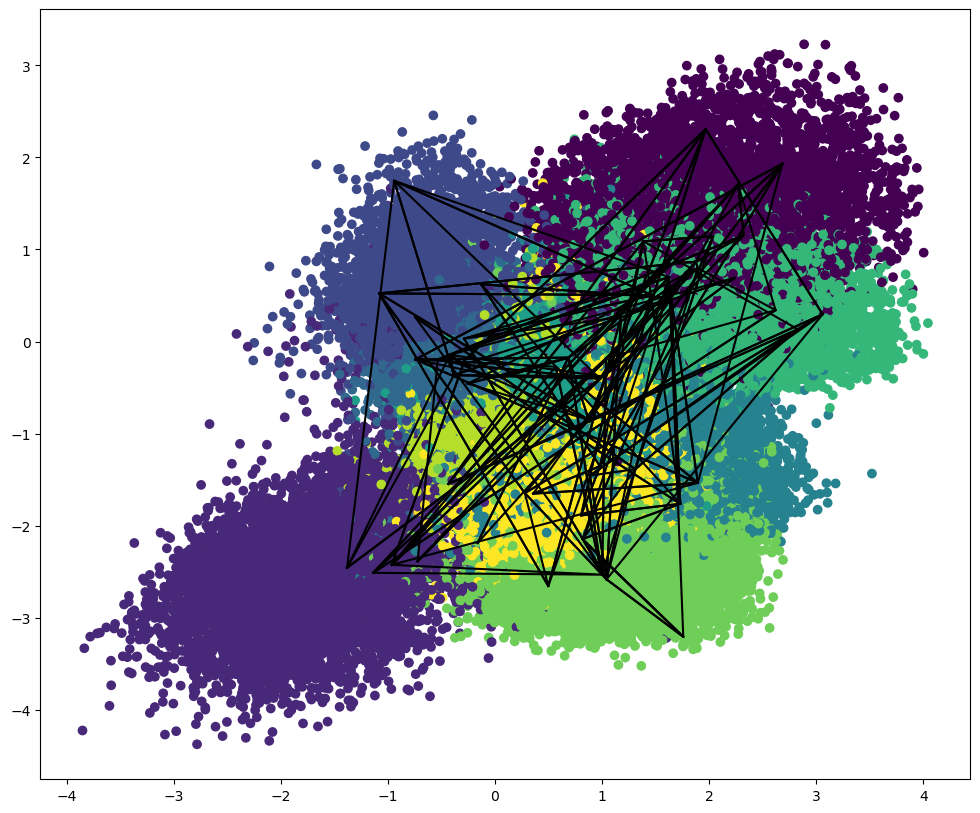

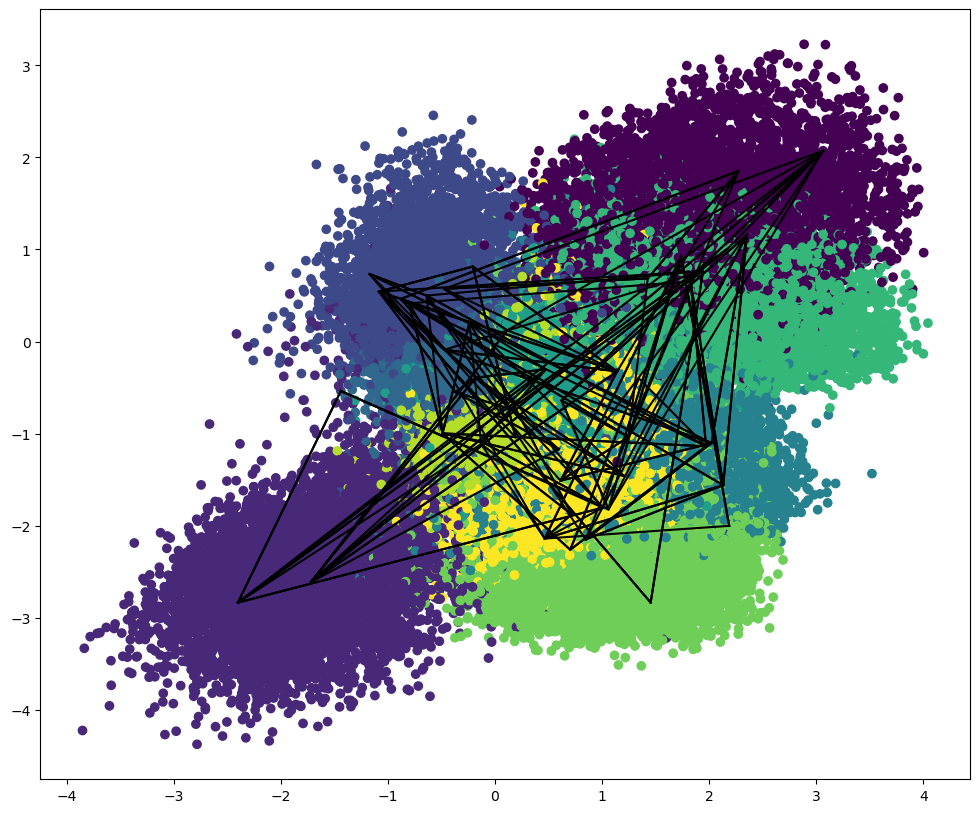

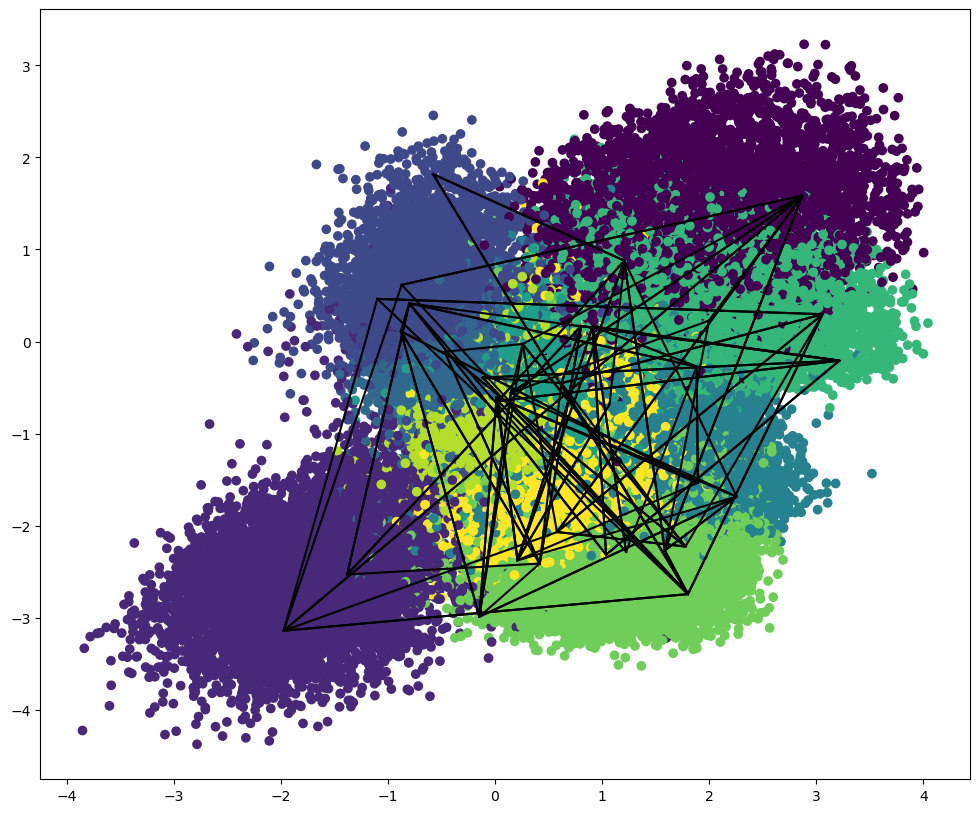

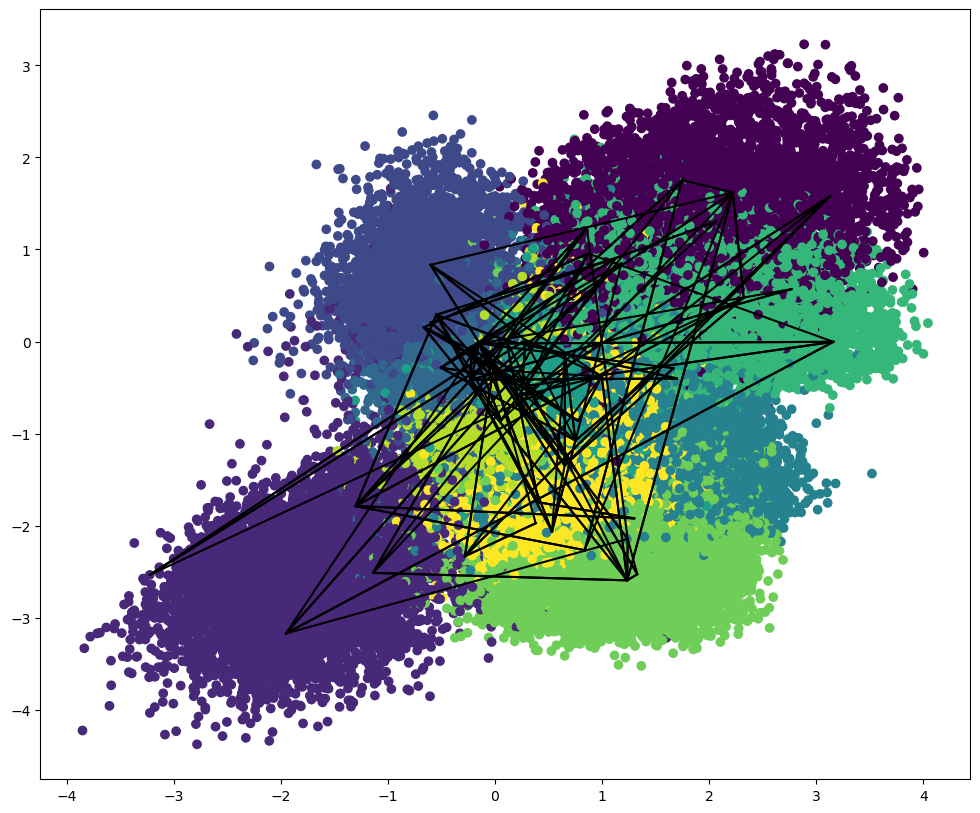

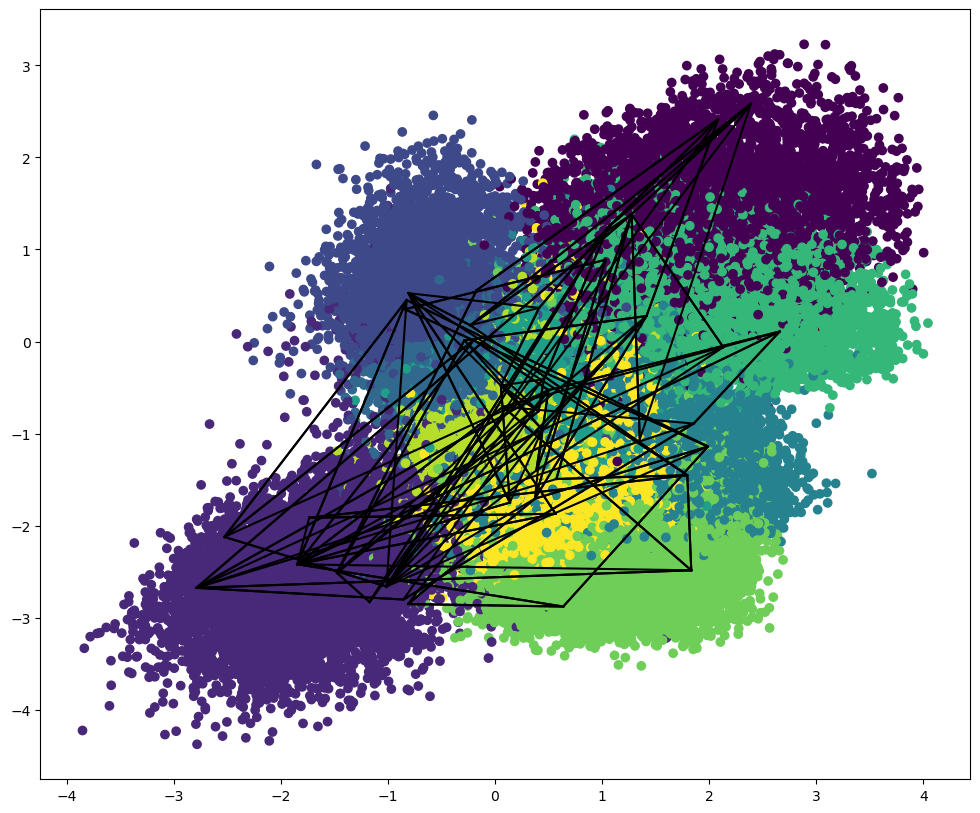

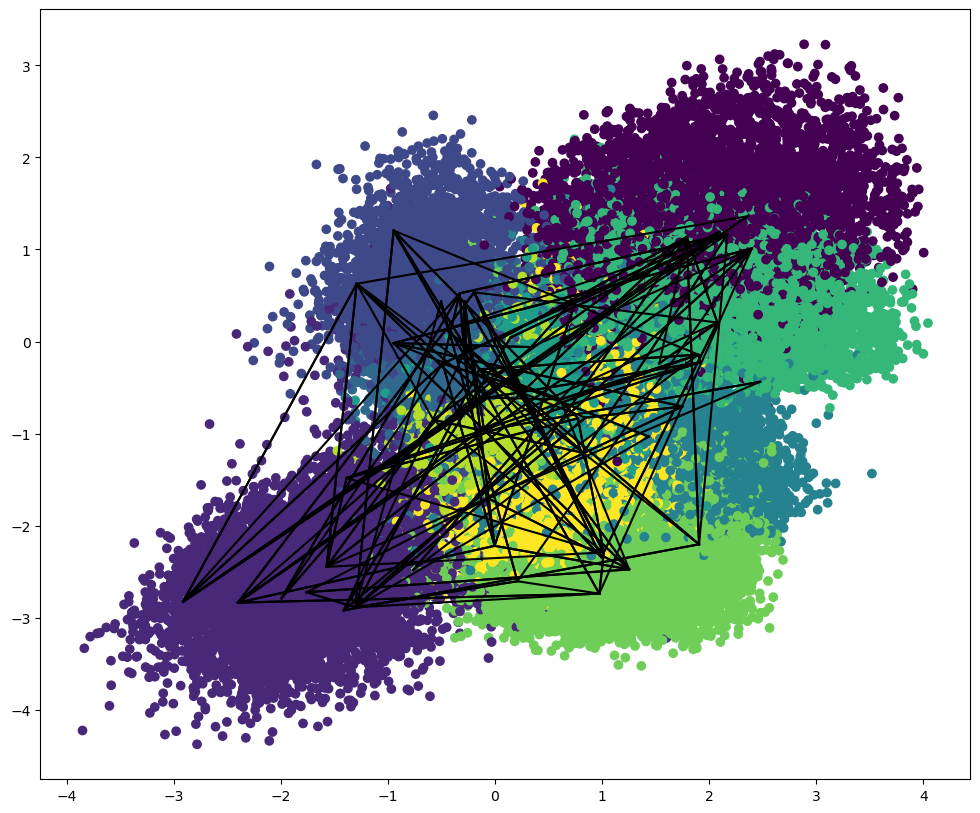

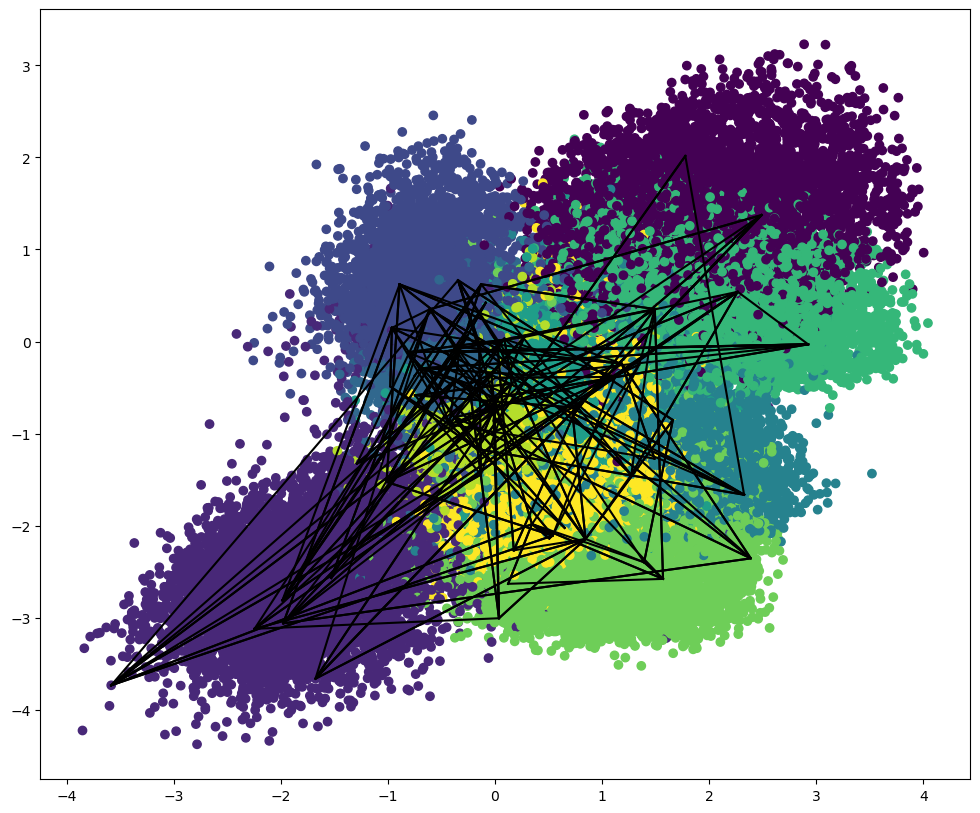

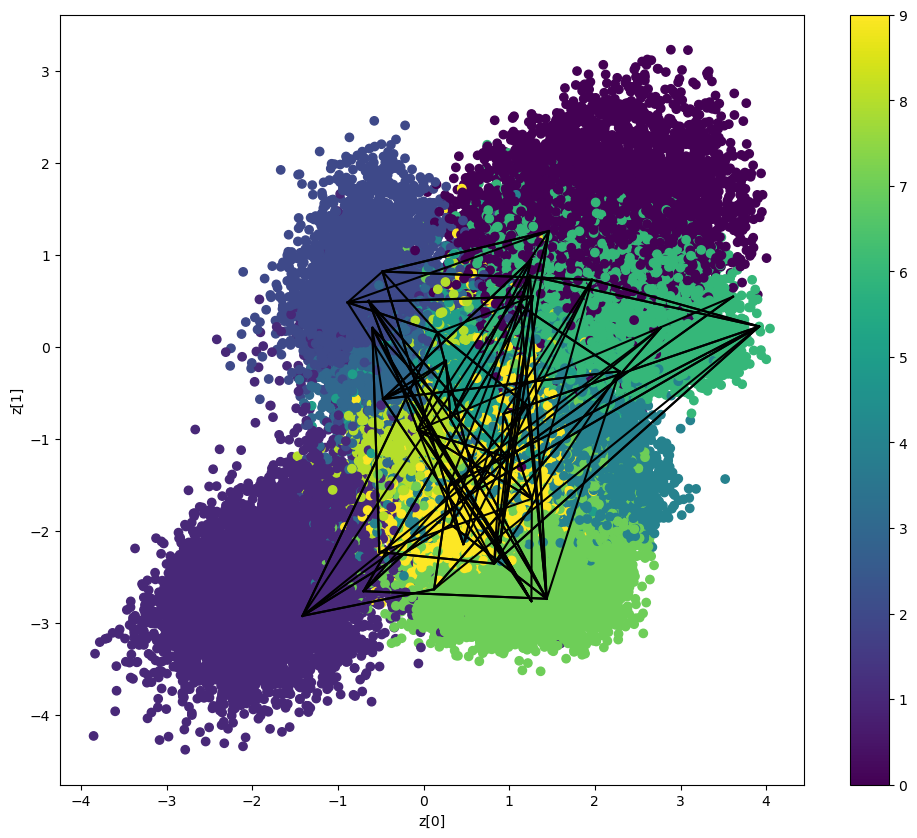

In [11]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from operator import itemgetter

def plot_label_clusters(model, data, labels):
    # display a 2D plot of the digit classes in the latent space
    _,_,z = model.predict(data)
    l = zip(z,labels)
    sort_list = sorted(l,key = itemgetter(1))
    for i in range(9):
        sorted_list = [values for values,key in sort_list if key == i] 
        hull = ConvexHull(sorted_list)
        plt.figure(figsize=(12, 10))
        plt.scatter(z[:, 0], z[:, 1], c=labels)
        for simplex in hull.simplices:
            plt.plot(z[simplex,0],z[simplex,1],'k-')
            
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), (x_test,y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

plot_label_clusters(encoder_model, x_train, y_train)

##Ask question whether it makes sense to bound sample values or mean values

In [ ]:

model_path = "models/MNIST_model"
m = tf.saved_model.load(model_path)
#z_sample = vae.encoder.predict(x_test)
#x_decoded = vae.decoder.predict(z_sample[2])
x_decoded = vae_m.predict(x_test)

In [ ]:
 # load the saved_model using low-level API
index = 295
plt.figure(1)
plt.imshow(x_decoded[index])
plt.title("This is the recreated image")

plt.figure(2)
plt.imshow(x_test[index])
plt.title("This is the original image")
print("This is the real label:" + str(y_test[index]))

prediction_from_decoder = m(x_decoded)
print("This is the predicted label of the recreated image:" + str(y_test[np.argmax(prediction_from_decoder[index])]))

prediction_input_image = m(x_test)
print("This is the predicted label of the original image:" + str(y_test[np.argmax(prediction_input_image[index])]))


#tfm = tf.function(lambda x: m(x))  # full model   
#tfm.summary()